In [1]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
#import pmdarima as pm
#import tensorflow as tf
import xgboost as xgb
#from bayes_opt import BayesianOptimization
#from fbprophet import Prophet
#from gluonts.dataset.common import ListDataset
#from gluonts.evaluation.backtest import make_evaluation_predictions
#from gluonts.model.deepar import DeepAREstimator
#from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

#from utils.metrics import evaluate


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

df1 = pd.read_csv(r'C:\Users\uddandam.prakash\Downloads\tsa_model_base_v1.csv', parse_dates=['part_date'])
df1.set_index('part_date', inplace=True)

In [2]:
df1.head()

,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange
part_date,,,,,
2021-10-01,"1,701,336","1,492,856.05",2.8083,0.2,175
2021-10-02,"1,696,106","1,467,424.57",2.8083,0.2,175
2021-10-03,"1,453,001","1,285,924.08",2.8083,0.2,175
2021-10-04,"1,640,321","1,468,525.83",2.8083,0.2,175
2021-10-05,"1,634,891","1,458,418.87",2.8083,0.2,175


In [3]:
df1.isnull().sum()

cdr_og_netone_call_cnt     0
cdr_og_netone_call_mins    0
tariff_rate                0
termination_rate           0
rtgs_interbank_exchange    0
dtype: int64

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2021-10-01 to 2023-10-09
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cdr_og_netone_call_cnt   733 non-null    object 
 1   cdr_og_netone_call_mins  733 non-null    object 
 2   tariff_rate              733 non-null    float64
 3   termination_rate         733 non-null    float64
 4   rtgs_interbank_exchange  733 non-null    object 
dtypes: float64(2), object(3)
memory usage: 34.4+ KB


In [5]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
tariff_rate,733.0,11.442866,9.630959,2.8083,2.8083,7.27375,26.3626,26.3626
termination_rate,733.0,0.229315,0.028101,0.2000,0.2000,0.23400,0.2600,0.2600


In [6]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

df2 = pd.read_csv(r'C:\Users\uddandam.prakash\Downloads\tsa_model_base_v1.csv', parse_dates=['part_date'])
df2.set_index('part_date', inplace=True)

split_date = '2023-04-30'
df_training = df2.loc[df2.index <= split_date]
df_test = df2.loc[df2.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('C:/Users/uddandam.prakash/Downloads/training.csv')
df_test.to_csv('C:/Users/uddandam.prakash/Downloads/test.csv')

576 days of training data 
 157 days of testing data 


In [7]:
df2.columns

Index(['cdr_og_netone_call_cnt', 'cdr_og_netone_call_mins', 'tariff_rate',
       'termination_rate', 'rtgs_interbank_exchange'],
      dtype='object')

In [8]:
df2.head()

,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange
part_date,,,,,
2021-10-01,"1,701,336","1,492,856.05",2.8083,0.2,175
2021-10-02,"1,696,106","1,467,424.57",2.8083,0.2,175
2021-10-03,"1,453,001","1,285,924.08",2.8083,0.2,175
2021-10-04,"1,640,321","1,468,525.83",2.8083,0.2,175
2021-10-05,"1,634,891","1,458,418.87",2.8083,0.2,175


In [9]:

df2['cdr_og_netone_call_mins'] = df2.mean(axis=1)
# drop unwanted columns and resetting the datafreame
df2 = df2[['cdr_og_netone_call_mins']]
df2.head()

,cdr_og_netone_call_mins
part_date,
2021-10-01,1.50415
2021-10-02,1.50415
2021-10-03,1.50415
2021-10-04,1.50415
2021-10-05,1.50415


Text(0.5, 0, 'usage')

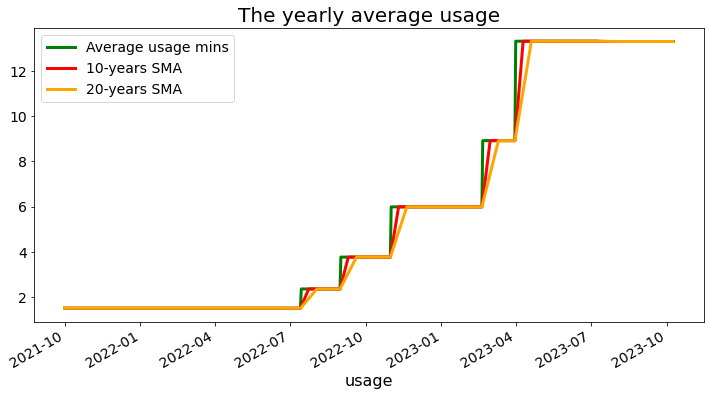

In [10]:
# SMA over a period of 10 and 20 years 
df2['SMA_10'] = df2.cdr_og_netone_call_mins.rolling(10, min_periods=1).mean()
df2['SMA_20'] = df2.cdr_og_netone_call_mins.rolling(20, min_periods=1).mean()

# Grean = Avg Air Temp, RED = 10 yrs, ORANG colors for the line plot
colors = ['green', 'red', 'orange']
# Line plot 
df2.plot(color=colors, linewidth=3, figsize=(12,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average usage mins', '10-years SMA', '20-years SMA'], fontsize=14)
plt.title('The yearly average usage', fontsize=20)
plt.xlabel('usage', fontsize=16)

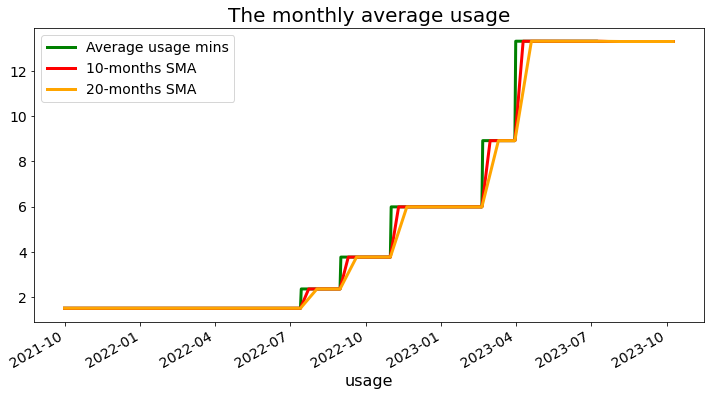

In [11]:
# SMA over a period of 10 and 20 months
df2['SMA_10'] = df2.cdr_og_netone_call_mins.rolling(10, min_periods=1).mean()
df2['SMA_20'] = df2.cdr_og_netone_call_mins.rolling(20, min_periods=1).mean()

# Green = Avg Air Temp, Red = 10 months, Orange = 20 months for the line plot
colors = ['green', 'red', 'orange']

# Line plot
df2.plot(color=colors, linewidth=3, figsize=(12, 6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['Average usage mins', '10-months SMA', '20-months SMA'], fontsize=14)
plt.title('The monthly average usage', fontsize=20)
plt.xlabel('usage', fontsize=16)

plt.show()


In [12]:
df2.columns

Index(['cdr_og_netone_call_mins', 'SMA_10', 'SMA_20'], dtype='object')

In [13]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

df3 = pd.read_csv(r'C:\Users\uddandam.prakash\Downloads\tsa_model_base_v1.csv', parse_dates=['part_date'])
df3.set_index('part_date', inplace=True)

split_date = '2023-04-30'
df_training = df3.loc[df2.index <= split_date]
df_test = df3.loc[df3.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

#df_training.to_csv('C:/Users/uddandam.prakash/Downloads/training.csv')
#df_test.to_csv('C:/Users/uddandam.prakash/Downloads/test.csv')

576 days of training data 
 157 days of testing data 


In [14]:
df3.head()

,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange
part_date,,,,,
2021-10-01,"1,701,336","1,492,856.05",2.8083,0.2,175
2021-10-02,"1,696,106","1,467,424.57",2.8083,0.2,175
2021-10-03,"1,453,001","1,285,924.08",2.8083,0.2,175
2021-10-04,"1,640,321","1,468,525.83",2.8083,0.2,175
2021-10-05,"1,634,891","1,458,418.87",2.8083,0.2,175


In [15]:

df3['rtgs_interbank_exchange'] = df3.mean(axis=1)
# drop unwanted columns and resetting the datafreame
df3 = df3[['rtgs_interbank_exchange']]
df3.head()

,rtgs_interbank_exchange
part_date,
2021-10-01,1.50415
2021-10-02,1.50415
2021-10-03,1.50415
2021-10-04,1.50415
2021-10-05,1.50415


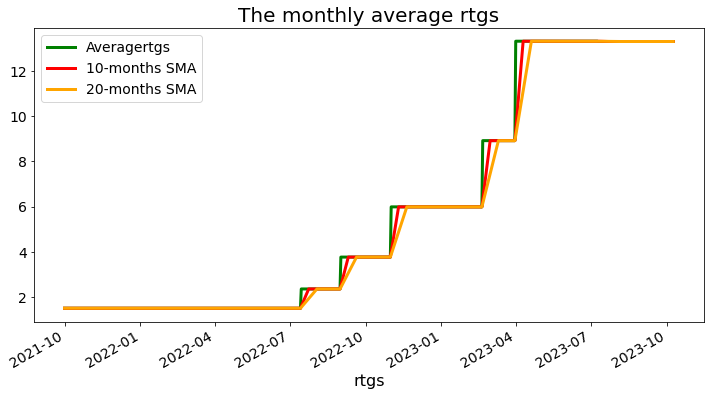

In [16]:
# SMA over a period of 10 and 20 months
df3['SMA_101'] = df3.rtgs_interbank_exchange.rolling(10, min_periods=1).mean()
df3['SMA_201'] = df3.rtgs_interbank_exchange.rolling(20, min_periods=1).mean()

# Green = Avg Air Temp, Red = 10 months, Orange = 20 months for the line plot
colors = ['green', 'red', 'orange']

# Line plot
df2.plot(color=colors, linewidth=3, figsize=(12, 6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['Averagertgs', '10-months SMA', '20-months SMA'], fontsize=14)
plt.title('The monthly average rtgs', fontsize=20)
plt.xlabel('rtgs', fontsize=16)

plt.show()


In [17]:
df2.columns

Index(['cdr_og_netone_call_mins', 'SMA_10', 'SMA_20'], dtype='object')

Cumulative Moving Average (CMA)
The CMA is the unweighted mean of past values till the current time.

Text(0, 0.5, 'usage')

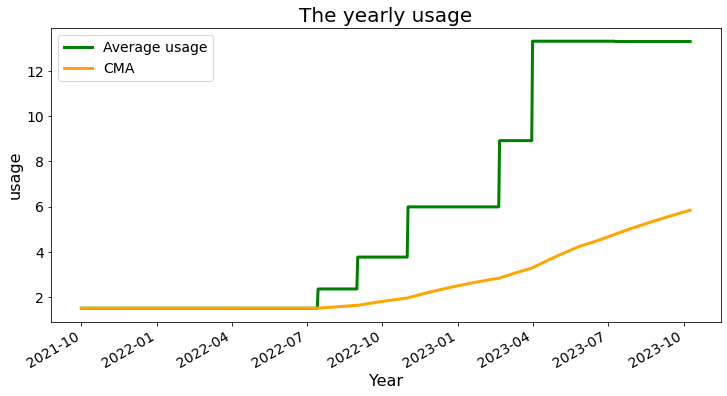

In [18]:
df2['CMA'] = df2.cdr_og_netone_call_mins.expanding().mean()

# green -Avg Air Temp and Orange -CMA
colors = ['green', 'orange']
# line plot
df2[['cdr_og_netone_call_mins', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average usage', 'CMA'], fontsize=14)
plt.title('The yearly usage', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('usage', fontsize=16)

Exponential Moving Average (EMA)
EMA is mainly used to identify trends and filter out noise. The weight of elements is decreased gradually over time. This means It gives weight to recent data points, not historical ones. Compared with SMA, the EMA is faster to change and more sensitive.

α –>Smoothing Factor.

It has a value between 0,1.
Represents the weighting applied to the very recent period.
Let’s apply the exponential moving averages with a smoothing factor of 0.1 and 0.3 in the given dataset.

In [19]:
df2.columns

Index(['cdr_og_netone_call_mins', 'SMA_10', 'SMA_20', 'CMA'], dtype='object')

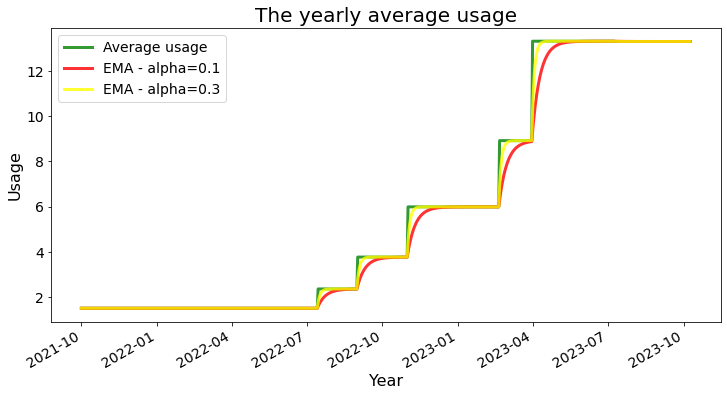

In [20]:
# Let's smoothing factor - 0.1
df2['EMA_0.1'] = df2.cdr_og_netone_call_mins.ewm(alpha=0.1, adjust=False).mean()
# Let's smoothing factor - 0.3
df2['EMA_0.3'] = df2.cdr_og_netone_call_mins.ewm(alpha=0.3, adjust=False).mean()

# Green - Avg Air Temp, Red - EMA with alpha=0.1, Yellow - EMA with alpha=0.3
colors = ['green', 'red', 'yellow']
df2[['cdr_og_netone_call_mins', 'EMA_0.1', 'EMA_0.3']].plot(color=colors, linewidth=3, figsize=(12, 6), alpha=0.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['Average usage', 'EMA - alpha=0.1', 'EMA - alpha=0.3'], fontsize=14)
plt.title('The yearly average usage', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Usage', fontsize=16)

plt.show()


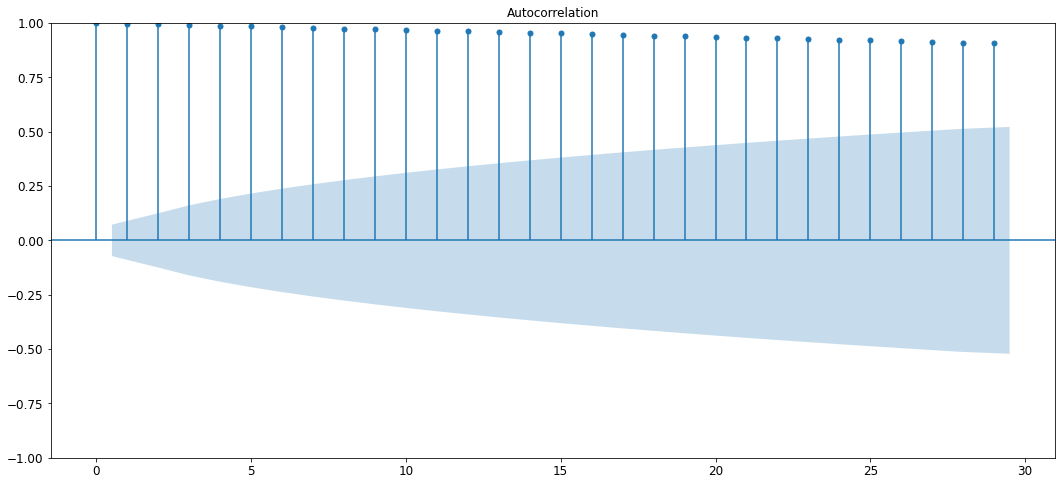

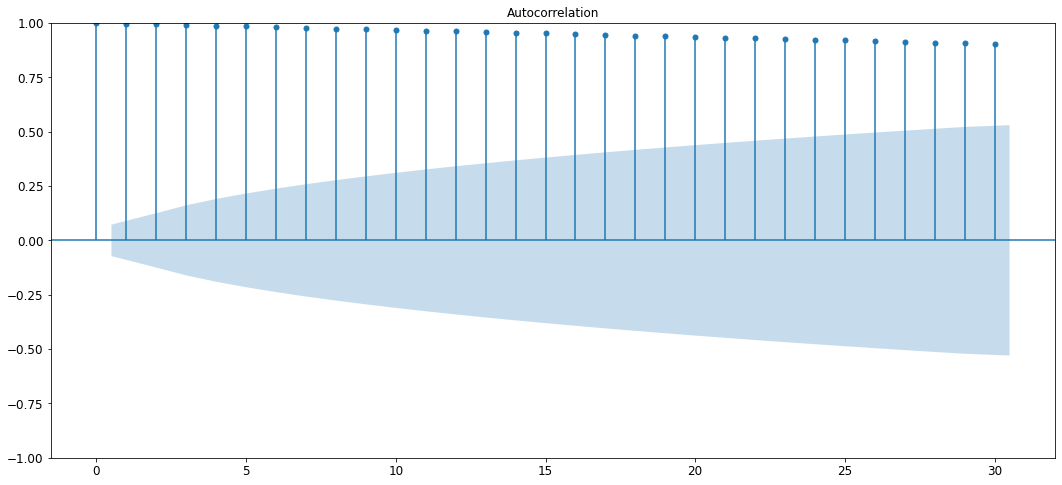

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

# Specify the column you want to compute ACF for (e.g., 'cdr_og_netone_call_mins')
column_name = 'cdr_og_netone_call_mins'

# Plot the ACF for the specified column
plot_acf(df2[column_name])
plt.show()

# Plot the ACF for the specified column with a specific number of lags (e.g., 30)
plot_acf(df2[column_name], lags=30)
plt.show()


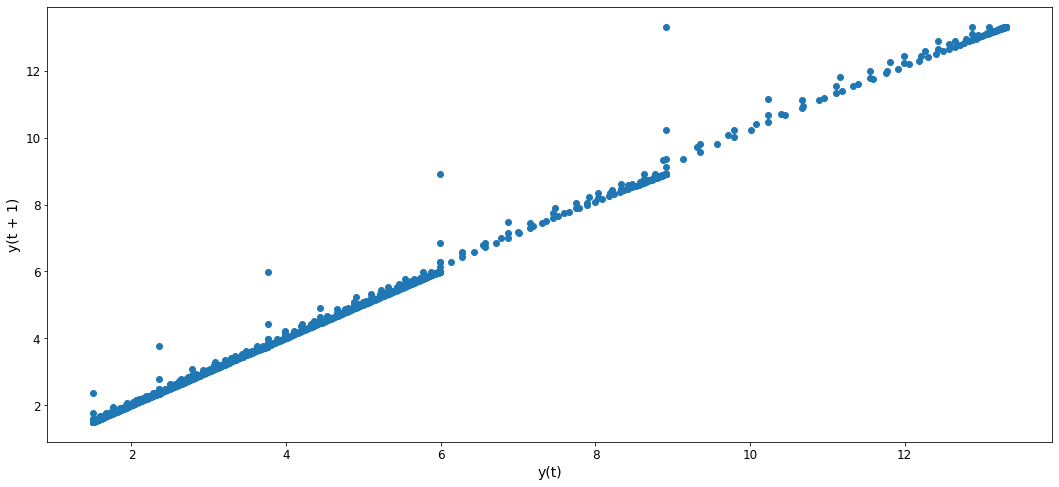

In [22]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(df2)
pyplot.show()

Coefficients: [ 1.71110948e-02  9.93757969e-01  7.00684397e-15 -1.68330761e-15
 -5.05561315e-16 -5.74612589e-15  8.38931493e-15 -4.85459725e-15
 -4.33762285e-15  1.57985684e-14 -6.16666178e-15 -5.17011156e-15
  5.25669900e-15  9.25126087e-16  3.47125172e-15  1.84295019e-15
 -4.88570221e-15  7.05208059e-15 -6.23455059e-15  7.44331612e-17
  6.53039299e-03]
predicted=13.319246, expected=13.298300
predicted=13.340061, expected=13.298300
predicted=13.360746, expected=13.298300
predicted=13.381302, expected=13.298300
predicted=13.401730, expected=13.298300
predicted=13.422030, expected=13.298300
predicted=13.442203, expected=13.298300
Test RMSE: 0.092


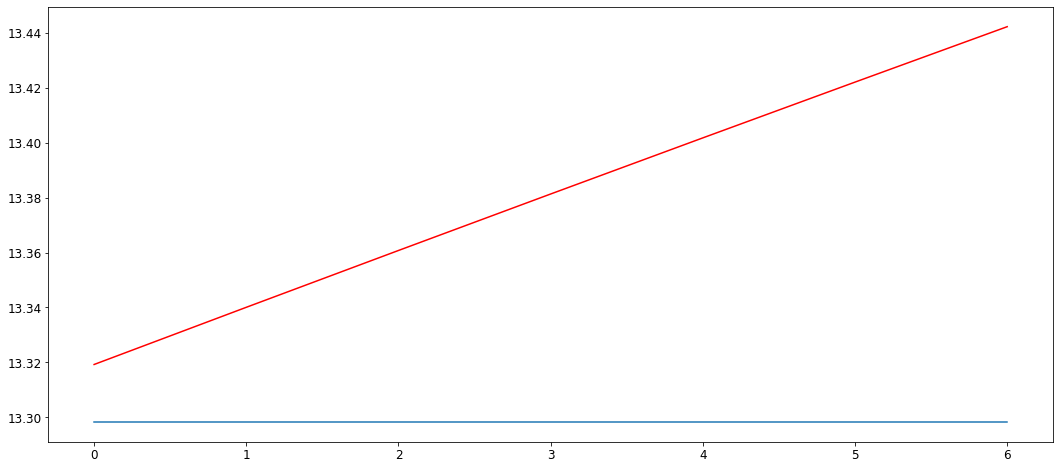

In [23]:
# import libraries
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# load csv as dataset
X = df2['cdr_og_netone_call_mins'].values  # Assuming 'cdr_og_netone_call_mins' is the column you want to use
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AutoReg(train, lags=20)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# Predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


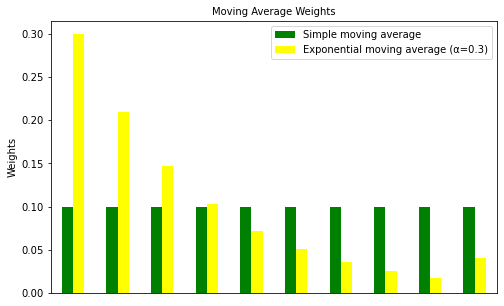

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

alpha = 0.3
n = 10
w_sma = np.repeat(1/n, n)
colors = ['green', 'yellow']

# weights - exponential moving average alpha=0.3 adjust=False
w_ema = [(1-alpha)**i if i==n-1 else alpha*(1-alpha)**i for i in range(n)]

pd.DataFrame({'w_sma': w_sma, 'w_ema': w_ema}).plot(color=colors, kind='bar', figsize=(8,5))
plt.xticks([])
plt.yticks(fontsize=10)
plt.legend(labels=['Simple moving average', 'Exponential moving average (α=0.3)'], fontsize=10)

# title and labels
plt.title('Moving Average Weights', fontsize=10)
plt.ylabel('Weights', fontsize=10)

plt.show()


In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Specify the column you want to use as the dependent variable
endog_column = 'cdr_og_netone_call_mins'

model = ARIMA(df2[endog_column], order=(0, 1, 1))
results_ARIMA = model.fit()

results_ARIMA.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     cdr_og_netone_call_mins   No. Observations:                  733
Model:                      ARIMA(0, 1, 1)   Log Likelihood                  68.505
Date:                     Wed, 11 Oct 2023   AIC                           -133.011
Time:                             11:17:59   BIC                           -123.819
Sample:                                  0   HQIC                          -129.465
                                     - 733                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1      -2.409e-07   5.08e-12  -4.74e+04      0.000   -2.41e-07   -2.41e-07
sigma2         0.0486      0.000    224.201      0.000       0.048       0.049
=================================================================================================
Ljung-Box (L1) (Q):                                 0.02   Jarque-Bera (JB):           2269725.23
Prob(Q):                                            0.88   Prob(JB):                         0.00
Heteroskedasticity (H): 93010556036400501046225403904.00   Skew:                            15.79
Prob(H) (two-sided):                                0.00   Kurtosis:                       273.96
=================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
forecasted_values = results_ARIMA.forecast(3)
forecasted_value_at_index_0 = forecasted_values.iloc[0]

print(forecasted_value_at_index_0)


13.298300000000001


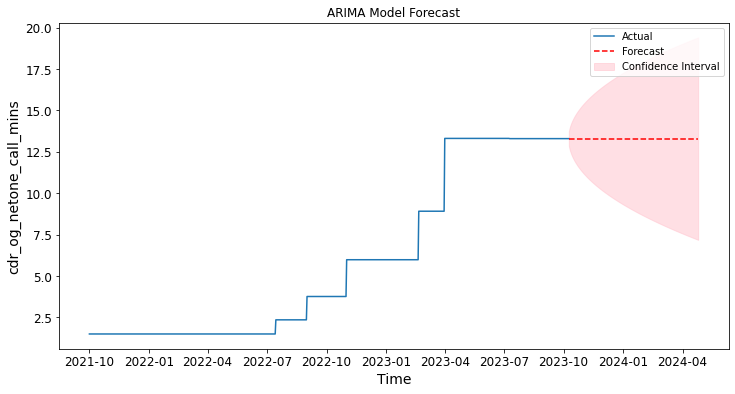

In [27]:
# Get a forecast object with confidence intervals
forecast = results_ARIMA.get_forecast(steps=200)

# Extract the mean forecast values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a range of indices for the forecasted values
forecast_index = pd.date_range(start=df2.index[-1], periods=200, freq='D')

# Plot the actual values, forecasted values, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(df2.index, df2['cdr_og_netone_call_mins'], label='Actual')
plt.plot(forecast_index, forecast_mean, color='red', label='Forecast', linestyle='--')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='Confidence Interval')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('cdr_og_netone_call_mins')
plt.show()


In [28]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [29]:
df11 = pd.read_csv(r'C:\Users\uddandam.prakash\Downloads\tsa_model_base_v1.csv')

In [30]:
df11.head()

,part_date,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange
0,20211001,"1,701,336","1,492,856.05",2.8083,0.2,175
1,20211002,"1,696,106","1,467,424.57",2.8083,0.2,175
2,20211003,"1,453,001","1,285,924.08",2.8083,0.2,175
3,20211004,"1,640,321","1,468,525.83",2.8083,0.2,175
4,20211005,"1,634,891","1,458,418.87",2.8083,0.2,175


In [48]:
df11['part_date'].min(), df11['part_date'].max()


KeyError: 'part_date'

In [32]:
df11.head()

,part_date,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange
0,20211001,"1,701,336","1,492,856.05",2.8083,0.2,175
1,20211002,"1,696,106","1,467,424.57",2.8083,0.2,175
2,20211003,"1,453,001","1,285,924.08",2.8083,0.2,175
3,20211004,"1,640,321","1,468,525.83",2.8083,0.2,175
4,20211005,"1,634,891","1,458,418.87",2.8083,0.2,175


In [33]:
from datetime import datetime

# Replace 'your_column_name' with the actual name of the column containing the date
df11['part_date'] = df11['part_date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d"))

# Format the datetime object as "YYYY-MM-DD"
df11['part_date'] = df11['part_date'].dt.strftime("%Y-%m-%d")

# Print the formatted date
print(df11.head())


    part_date cdr_og_netone_call_cnt cdr_og_netone_call_mins  tariff_rate  \
0  2021-10-01              1,701,336            1,492,856.05       2.8083   
1  2021-10-02              1,696,106            1,467,424.57       2.8083   
2  2021-10-03              1,453,001            1,285,924.08       2.8083   
3  2021-10-04              1,640,321            1,468,525.83       2.8083   
4  2021-10-05              1,634,891            1,458,418.87       2.8083   

   termination_rate rtgs_interbank_exchange  
0               0.2                     175  
1               0.2                     175  
2               0.2                     175  
3               0.2                     175  
4               0.2                     175  


In [34]:
df11 = df11.groupby('part_date')['cdr_og_netone_call_mins'].sum().reset_index()

In [35]:
df11.head()

,part_date,cdr_og_netone_call_mins
0,2021-10-01,"1,492,856.05"
1,2021-10-02,"1,467,424.57"
2,2021-10-03,"1,285,924.08"
3,2021-10-04,"1,468,525.83"
4,2021-10-05,"1,458,418.87"


In [36]:
# Assuming 'date_column' is the name of your datetime column in df11
df11['part_date'] = pd.to_datetime(df11['part_date'])
df11.set_index('part_date', inplace=True)
print(df11.head())


           cdr_og_netone_call_mins
part_date                         
2021-10-01            1,492,856.05
2021-10-02            1,467,424.57
2021-10-03            1,285,924.08
2021-10-04            1,468,525.83
2021-10-05            1,458,418.87


In [37]:
# Replace commas with empty strings and convert to numeric
df11['cdr_og_netone_call_mins'] = df11['cdr_og_netone_call_mins'].str.replace(',', '', regex=True).astype(float)

# Now you can resample and calculate the mean
y = df11['cdr_og_netone_call_mins'].resample('MS').mean()


In [38]:
y.head()

part_date
2021-10-01    1.371019e+06
2021-11-01    1.379638e+06
2021-12-01    1.612446e+06
2022-01-01    1.461913e+06
2022-02-01    1.634205e+06
Freq: MS, Name: cdr_og_netone_call_mins, dtype: float64

In [39]:
y['2021':]

part_date
2021-10-01    1.371019e+06
2021-11-01    1.379638e+06
2021-12-01    1.612446e+06
2022-01-01    1.461913e+06
2022-02-01    1.634205e+06
2022-03-01    1.722919e+06
2022-04-01    1.868078e+06
2022-05-01    2.115309e+06
2022-06-01    2.272105e+06
2022-07-01    2.359190e+06
2022-08-01    2.497241e+06
2022-09-01    2.471965e+06
2022-10-01    2.644086e+06
2022-11-01    2.387655e+06
2022-12-01    2.601437e+06
2023-01-01    2.424948e+06
2023-02-01    2.381272e+06
2023-03-01    2.327484e+06
2023-04-01    2.404567e+06
2023-05-01    2.368473e+06
2023-06-01    2.632816e+06
2023-07-01    2.882483e+06
2023-08-01    2.936565e+06
2023-09-01    2.989023e+06
2023-10-01    3.197017e+06
Freq: MS, Name: cdr_og_netone_call_mins, dtype: float64

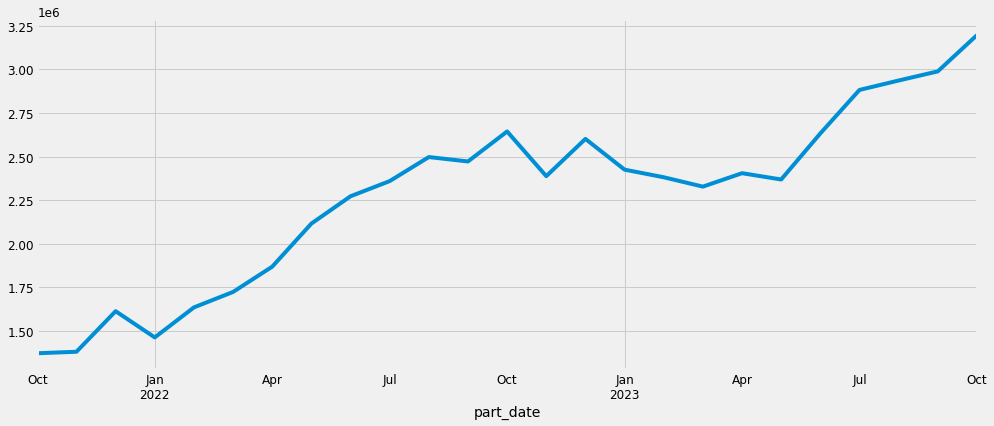

In [40]:
y.plot(figsize=(15, 6))
plt.show()

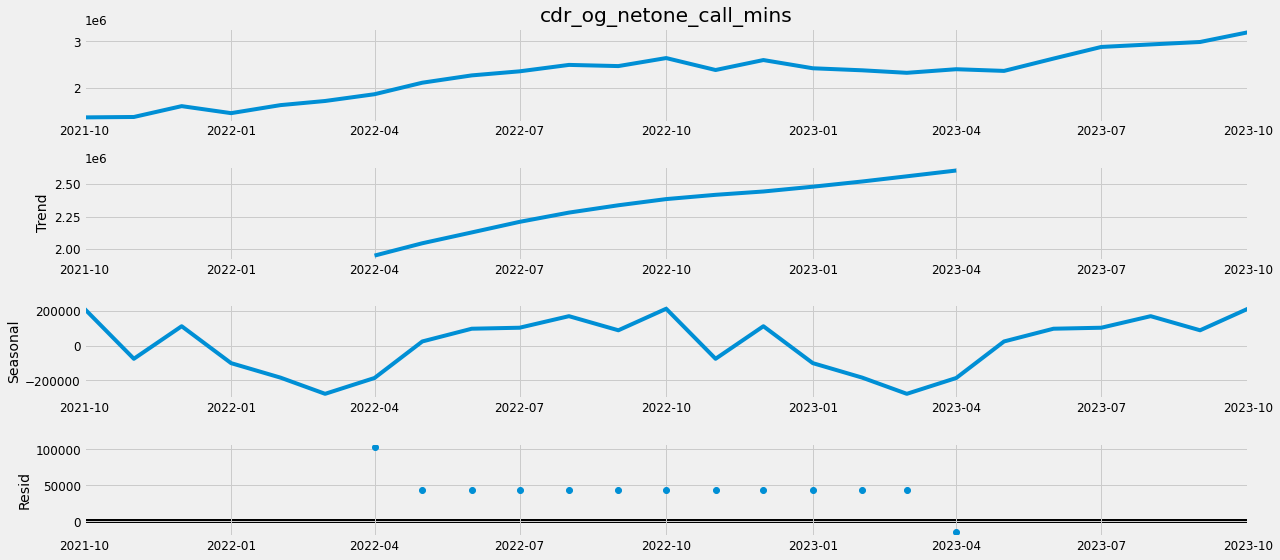

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [42]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [43]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:774.5653180917017
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:346.5249285162352
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:359.5321748593316
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:376.91987763702116
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:348.8381846500885
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:30.975901469243443
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:729.1788454580777
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:350.1198466869263
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:318.66587972244065
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:412.6837092022432
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:352.0674937218156
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:34.17096590232832
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:619.5281374632748
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:293.2123264054014
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:295.19597899272304
ARIMA(0

In [44]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0894         -0       -inf      0.000       1.089       1.089
ma.L1         -0.9466         -0        inf      0.000      -0.947      -0.947
ar.S.L12            0         -0        nan        nan           0           0
sigma2      1.911e+10         -0       -inf      0.000    1.91e+10    1.91e+10


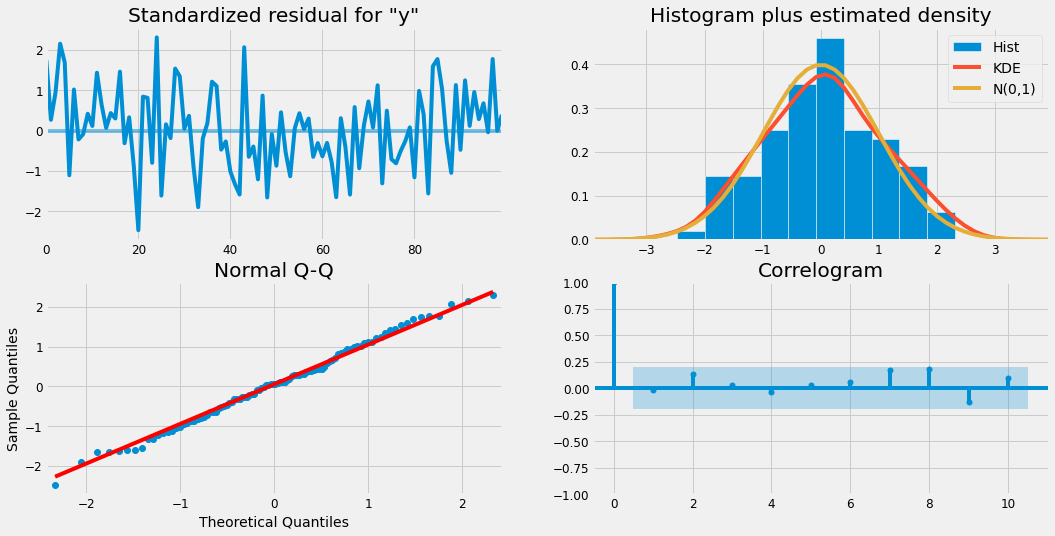

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Simulate a time series (replace this with your actual data)
np.random.seed(0)
y = np.random.randn(100)

# Define the SARIMAX model
order = (1, 0, 0)  # Replace with your desired order
seasonal_order = (0, 0, 0, 0)  # Replace with your desired seasonal order

mod = sm.tsa.statespace.SARIMAX(y, order=order, seasonal_order=seasonal_order)
results = mod.fit()

# Plot diagnostics
try:
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
except ValueError as e:
    print("Error:", e)
    print("Make sure you have enough data or consider reducing the number of lags.")


## version 3 

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [157]:
data = pd.read_csv(r'C:\Users\uddandam.prakash\Downloads\tsa_model_base_v1.csv')  
data['part_date'] = pd.to_datetime(data['part_date'], format='%Y%m%d')
data.set_index('part_date', inplace=True)


In [158]:
data.head()

,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange
part_date,,,,,
2021-10-01,1701336,1492856,2.8083,0.2,175
2021-10-02,1696106,1467425,2.8083,0.2,175
2021-10-03,1453001,1285924,2.8083,0.2,175
2021-10-04,1640321,1468526,2.8083,0.2,175
2021-10-05,1634891,1458419,2.8083,0.2,175


In [159]:
data.dtypes

cdr_og_netone_call_cnt       int64
cdr_og_netone_call_mins      int64
tariff_rate                float64
termination_rate           float64
rtgs_interbank_exchange      int64
dtype: object

In [160]:
data.isnull().sum()

cdr_og_netone_call_cnt     0
cdr_og_netone_call_mins    0
tariff_rate                0
termination_rate           0
rtgs_interbank_exchange    0
dtype: int64

In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2021-10-01 to 2023-10-09
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cdr_og_netone_call_cnt   733 non-null    int64  
 1   cdr_og_netone_call_mins  733 non-null    int64  
 2   tariff_rate              733 non-null    float64
 3   termination_rate         733 non-null    float64
 4   rtgs_interbank_exchange  733 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 34.4 KB


In [162]:
data.head()

,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange
part_date,,,,,
2021-10-01,1701336,1492856,2.8083,0.2,175
2021-10-02,1696106,1467425,2.8083,0.2,175
2021-10-03,1453001,1285924,2.8083,0.2,175
2021-10-04,1640321,1468526,2.8083,0.2,175
2021-10-05,1634891,1458419,2.8083,0.2,175


In [163]:
data.columns

Index(['cdr_og_netone_call_cnt', 'cdr_og_netone_call_mins', 'tariff_rate',
       'termination_rate', 'rtgs_interbank_exchange'],
      dtype='object')

In [164]:
data.dtypes

cdr_og_netone_call_cnt       int64
cdr_og_netone_call_mins      int64
tariff_rate                float64
termination_rate           float64
rtgs_interbank_exchange      int64
dtype: object

In [165]:
data['cdr_og_netone_call_cnt'].max()

3362320

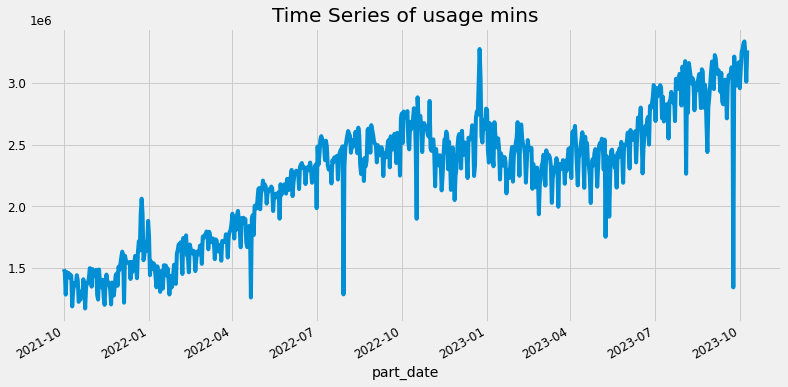

In [166]:
data['cdr_og_netone_call_mins'].plot(figsize=(12, 6))
plt.title('Time Series of usage mins')
plt.show()


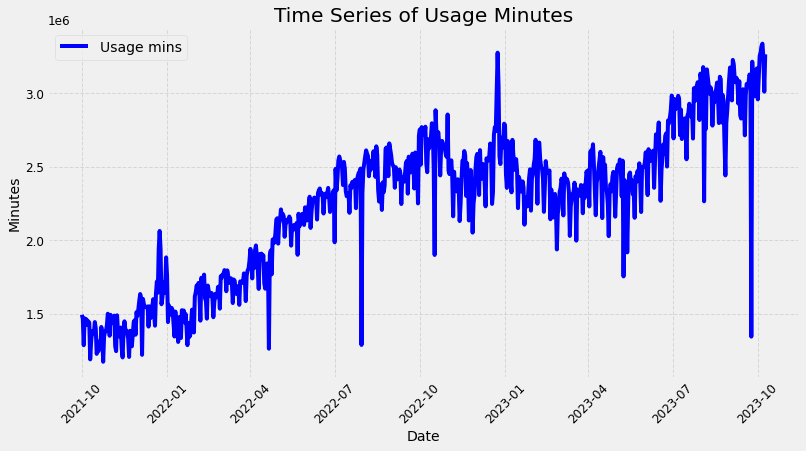

In [167]:

# Set the figure size and create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data as a time series
ax.plot(data.index, data['cdr_og_netone_call_mins'], label='Usage mins', color='blue', linestyle='-')

# Customize the plot
ax.set_title('Time Series of Usage Minutes')
ax.set_xlabel('Date')
ax.set_ylabel('Minutes')
ax.legend()

# You can further customize the plot by adding grid lines, labels, etc.
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()


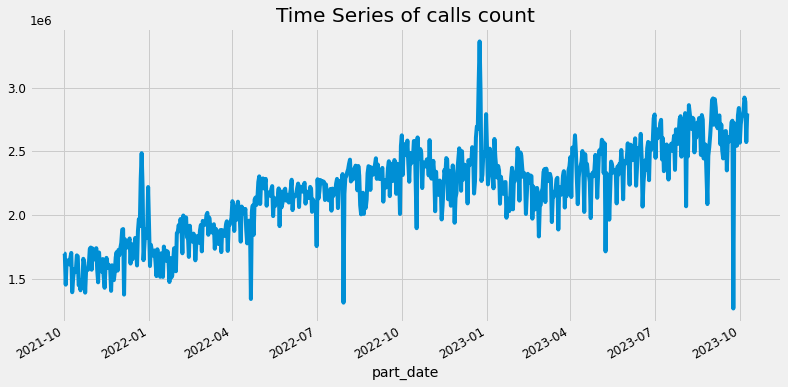

In [168]:
data['cdr_og_netone_call_cnt'].plot(figsize=(12, 6))
plt.title('Time Series of calls count')
plt.show()


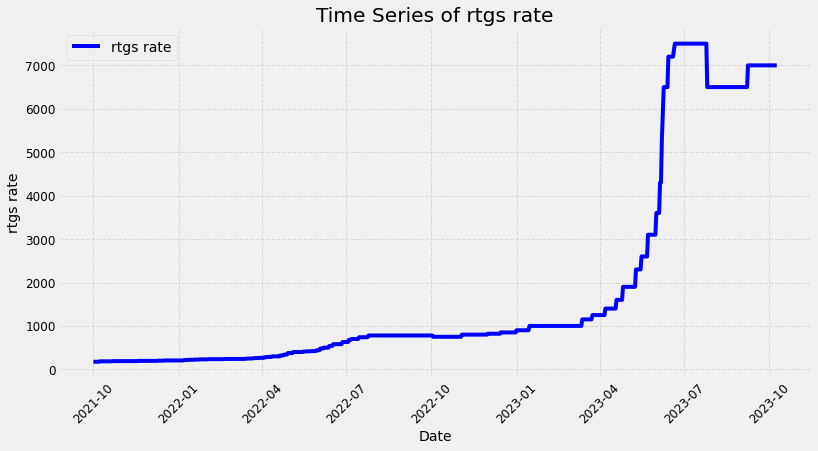

In [169]:

# Set the figure size and create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data as a time series
ax.plot(data.index, data['rtgs_interbank_exchange'], label='rtgs rate', color='blue', linestyle='-')

# Customize the plot
ax.set_title('Time Series of rtgs rate')
ax.set_xlabel('Date')
ax.set_ylabel('rtgs rate')
ax.legend()

# You can further customize the plot by adding grid lines, labels, etc.
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()


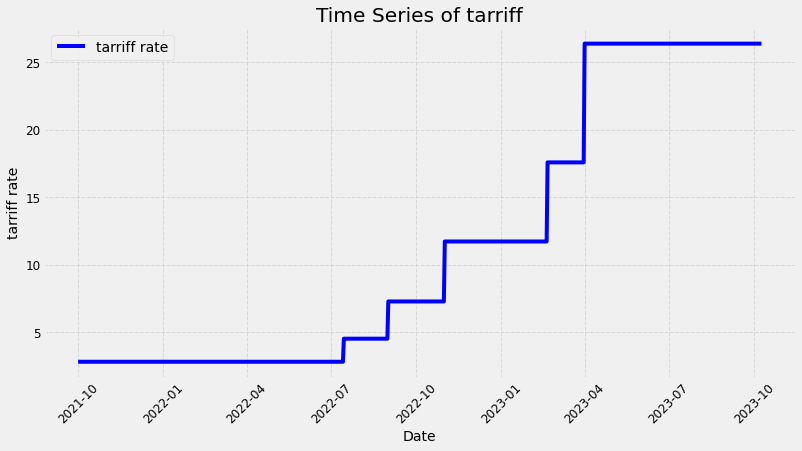

In [170]:

# Set the figure size and create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data as a time series
ax.plot(data.index, data['tariff_rate'], label='tarriff rate', color='blue', linestyle='-')

# Customize the plot
ax.set_title('Time Series of tarriff')
ax.set_xlabel('Date')
ax.set_ylabel('tarriff rate')
ax.legend()

# You can further customize the plot by adding grid lines, labels, etc.
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()


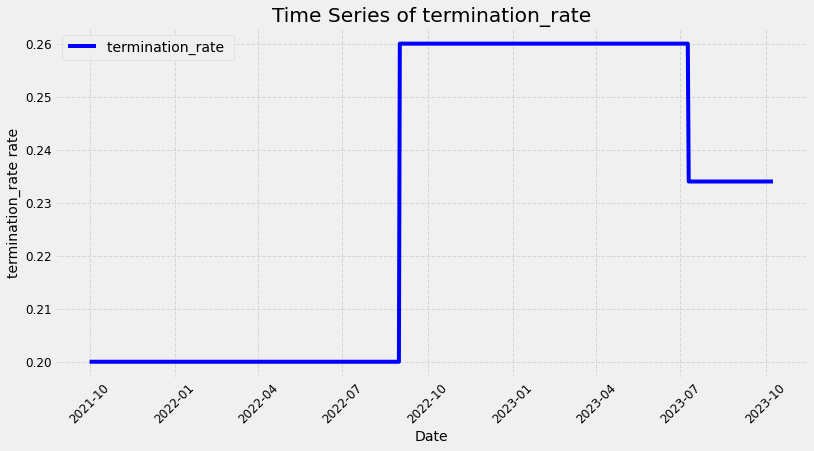

In [171]:

# Set the figure size and create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data as a time series
ax.plot(data.index, data['termination_rate'], label='termination_rate ', color='blue', linestyle='-')

# Customize the plot
ax.set_title('Time Series of termination_rate')
ax.set_xlabel('Date')
ax.set_ylabel('termination_rate rate')
ax.legend()

# You can further customize the plot by adding grid lines, labels, etc.
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()


<AxesSubplot:xlabel='part_date'>

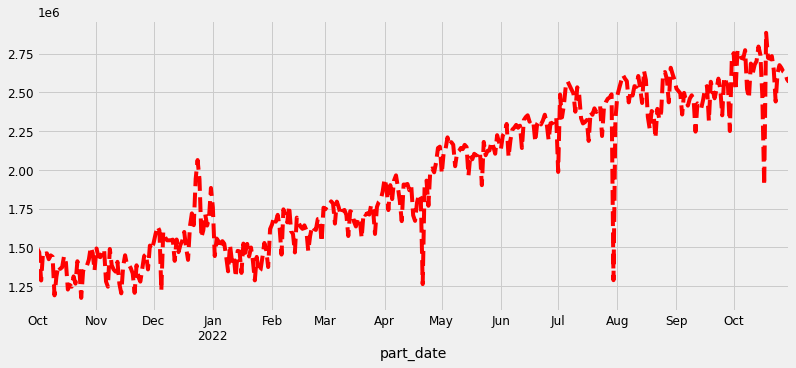

In [176]:
data['cdr_og_netone_call_mins']['2021-10-01':'2022-10-30'].plot(figsize=(12,5), ls='--', color='red')

<AxesSubplot:xlabel='part_date'>

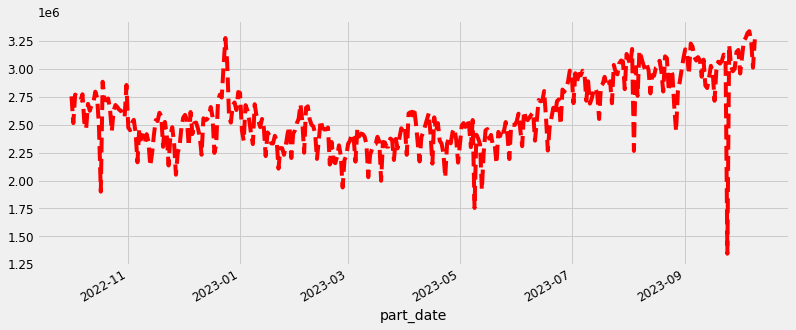

In [177]:
data['cdr_og_netone_call_mins']['2022-10-01':'2023-10-09'].plot(figsize=(12,5), ls='--', color='red')

<AxesSubplot:xlabel='part_date'>

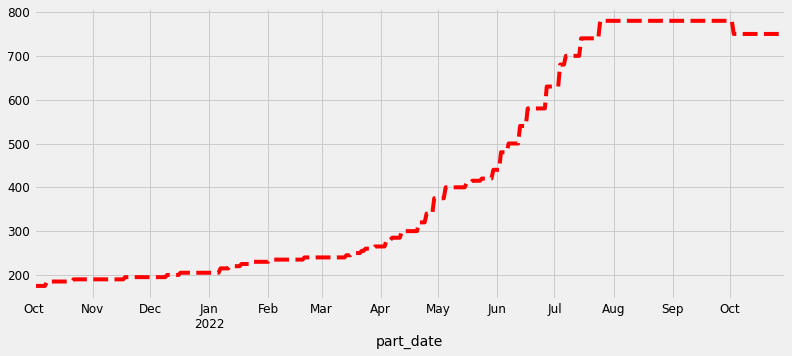

In [178]:
data['rtgs_interbank_exchange']['2021-10-01':'2022-10-30'].plot(figsize=(12,5), ls='--', color='red')

<AxesSubplot:xlabel='part_date'>

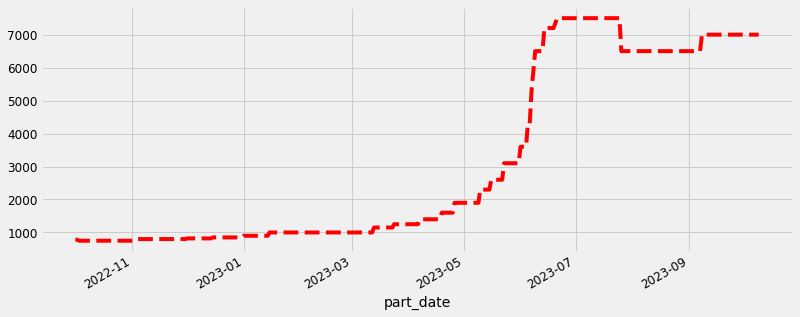

In [179]:
data['rtgs_interbank_exchange']['2022-10-01':'2023-10-09'].plot(figsize=(12,5), ls='--', color='red')

<AxesSubplot:xlabel='part_date'>

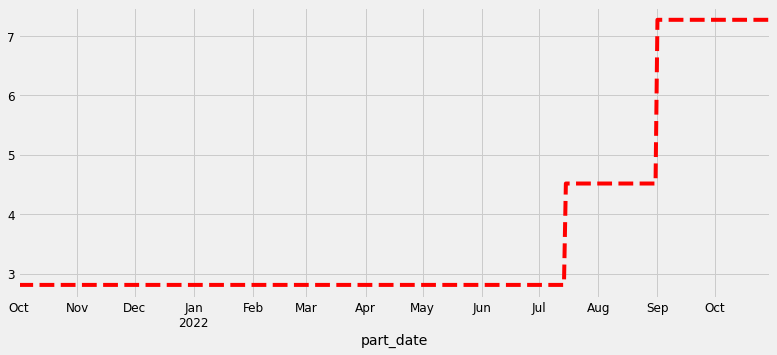

In [180]:
data['tariff_rate']['2021-10-01':'2022-10-30'].plot(figsize=(12,5), ls='--', color='red')

<AxesSubplot:xlabel='part_date'>

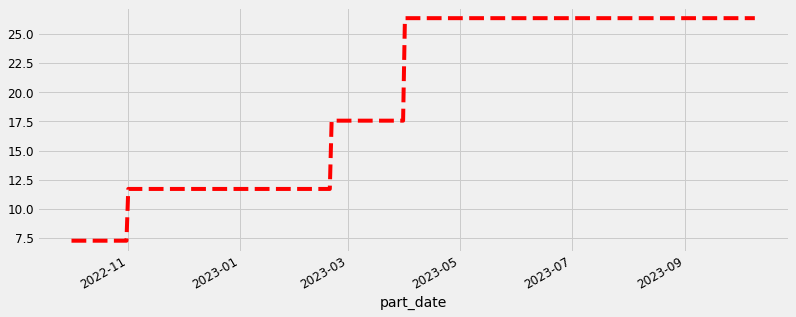

In [181]:
data['tariff_rate']['2022-10-01':'2023-10-30'].plot(figsize=(12,5), ls='--', color='red')

# time series analysis with stats models

# Introduction to Statsmodels
Statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. The package is released under the open source Modified BSD (3-clause) license. The online documentation is hosted at statsmodels.org. The statsmodels version used in the development of this course is 0.9.0.

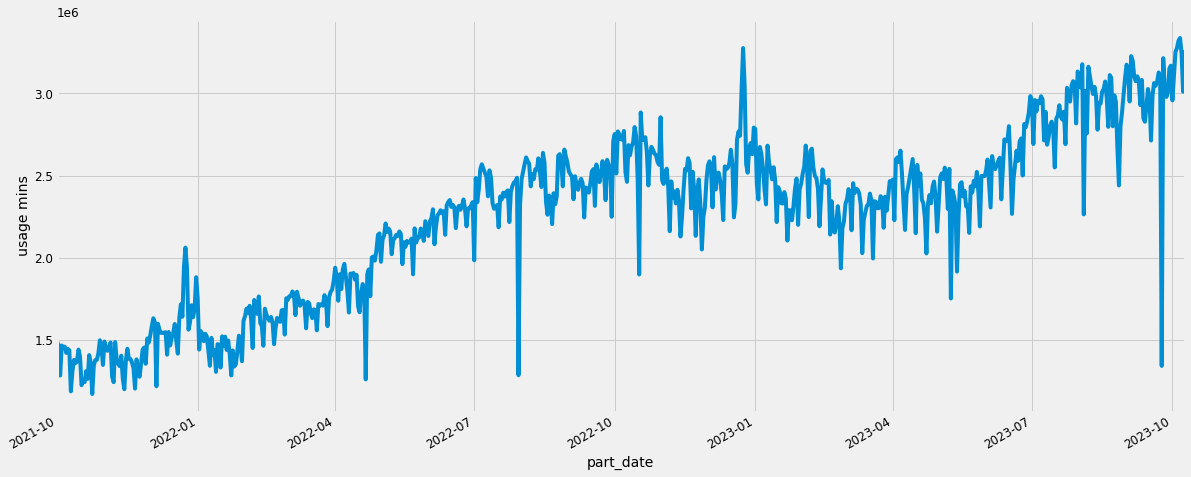

In [183]:
ax = data['cdr_og_netone_call_mins'].plot()
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='usage mins');

# Using statsmodels to get the trend
The Hodrick-Prescott filter separates a time-series 𝑦𝑡 into a trend component 𝜏𝑡 and a cyclical component 𝑐𝑡 𝑦𝑡=𝜏𝑡+𝑐𝑡 The components are determined by minimizing the following quadratic loss function, where 𝜆 is a smoothing parameter:

min𝜏𝑡∑𝑇𝑡=1𝑐2𝑡+𝜆∑𝑇𝑡=1[(𝜏𝑡−𝜏𝑡−1)−(𝜏𝑡−1−𝜏𝑡−2)]2 The 𝜆 value above handles variations in the growth rate of the trend component. When analyzing quarterly data, the default lambda value of 1600 is recommended. Use 6.25 for annual data, and 129,600 for monthly data.

In [185]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Tuple unpacking
usage_mins, usgae_trend = hpfilter(data['cdr_og_netone_call_mins'], lamb=1600)

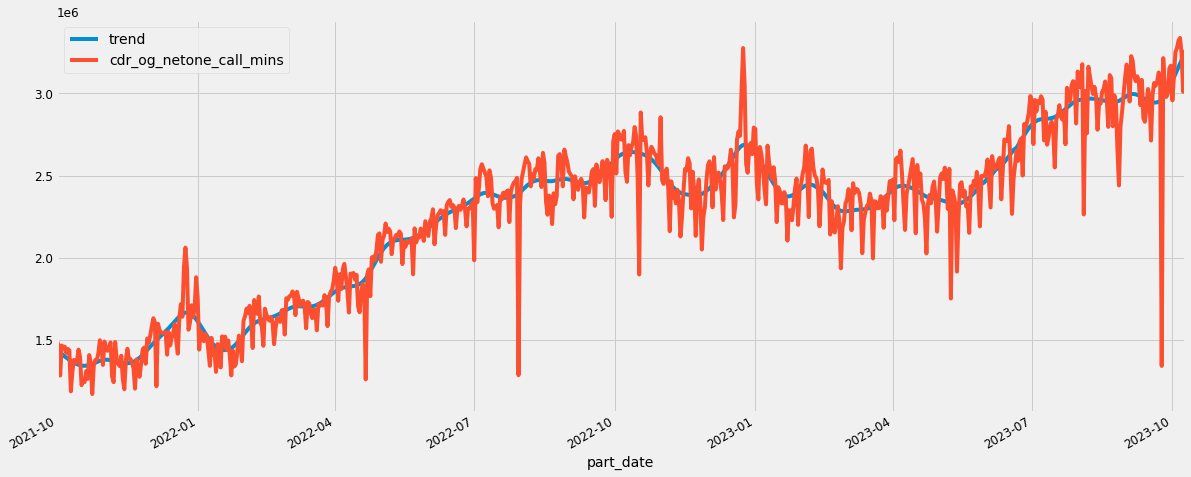

In [188]:
data['trend'] = usgae_trend
data[['trend','cdr_og_netone_call_mins']].plot().autoscale(axis='x',tight=True);

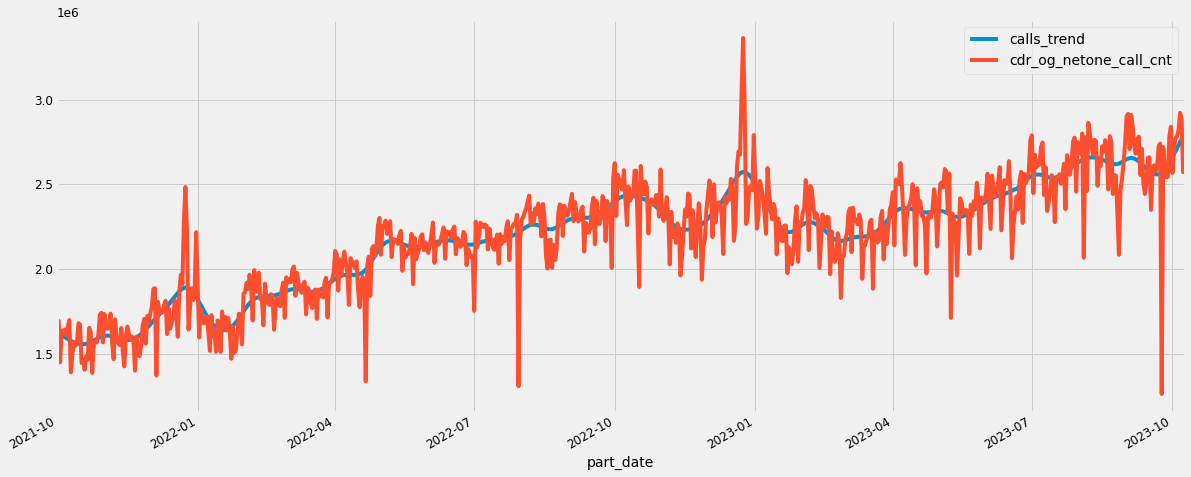

In [189]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Tuple unpacking
no_calls, calls_trend = hpfilter(data['cdr_og_netone_call_cnt'], lamb=1600)
data['calls_trend'] = calls_trend
data[['calls_trend','cdr_og_netone_call_cnt']].plot().autoscale(axis='x',tight=True);

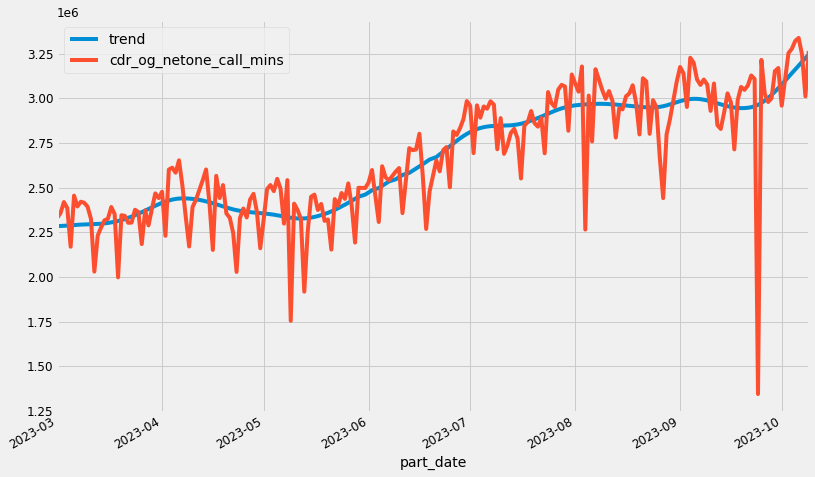

In [191]:
data[['trend','cdr_og_netone_call_mins']]['2023-03-01':].plot(figsize=(12,8)).autoscale(axis='x',tight=True);


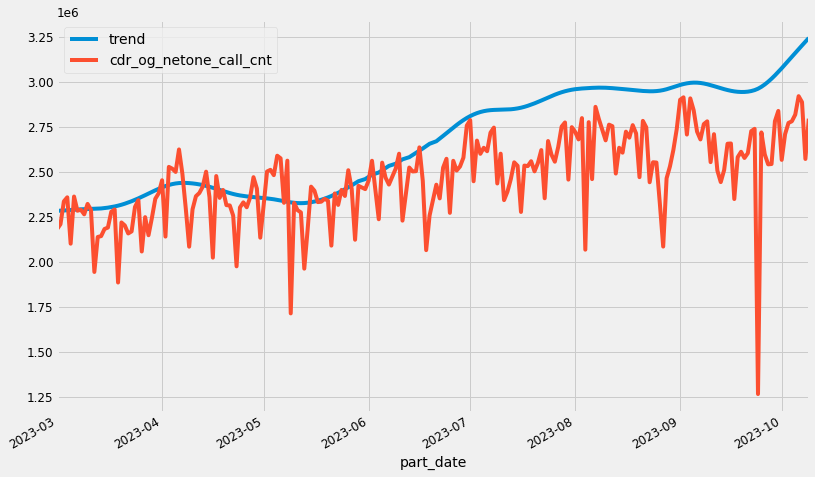

In [193]:
data[['trend','cdr_og_netone_call_cnt']]['2023-03-01':].plot(figsize=(12,8)).autoscale(axis='x',tight=True);


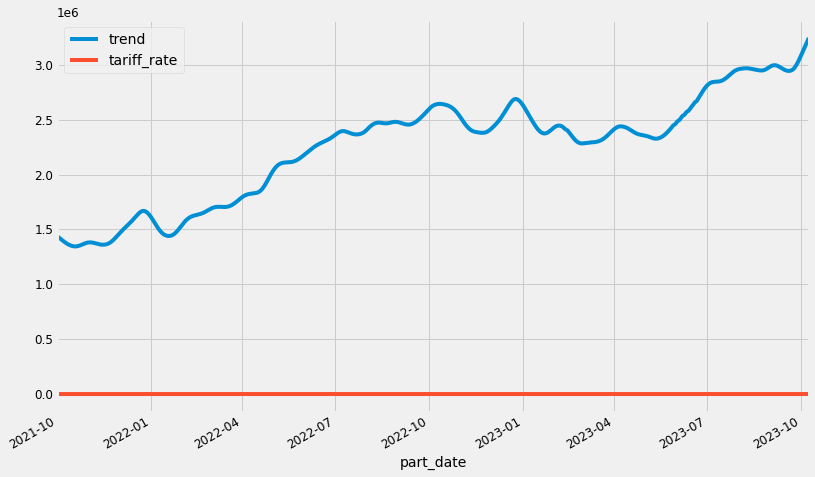

In [195]:
data[['trend','tariff_rate']]['2021-10-01':].plot(figsize=(12,8)).autoscale(axis='x',tight=True);


 ETS Models ( Error, Trend, Seasonality)
Exponential smooting
Trend methods models
ETS Decomposition
As we begin working with endogenous data ("endog" for short) and start to develop forecasting models, it helps to identify and isolate factors working within the system that influence behavior. Here the name "endogenous" considers internal factors, while "exogenous" would relate to external forces. These fall under the category of state space models, and include decomposition (described below), and exponential smoothing (described in an upcoming section).

The decomposition of a time series attempts to isolate individual components such as error, trend, and seasonality (ETS). We've already seen a simplistic example of this in the Introduction to Statsmodels section with the Hodrick-Prescott filter. There we separated data into a trendline and a cyclical feature that mapped observed data back to the trend.

# simple moving average

In [197]:
data['6-month-SMA'] = data['cdr_og_netone_call_mins'].rolling(window=6).mean()
data['12-month-SMA'] = data['cdr_og_netone_call_mins'].rolling(window=12).mean()
data.head(15)

,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange,trend,calls_trend,rtgs_trend,6-month-SMA,12-month-SMA
part_date,,,,,,,,,,
2021-10-01,1701336,1492856,2.8083,0.2,175,1.439126e+06,1.632251e+06,1.632251e+06,NaN,NaN
2021-10-02,1696106,1467425,2.8083,0.2,175,1.431597e+06,1.625867e+06,1.625867e+06,NaN,NaN
2021-10-03,1453001,1285924,2.8083,0.2,175,1.424103e+06,1.619526e+06,1.619526e+06,NaN,NaN
2021-10-04,1640321,1468526,2.8083,0.2,175,1.416697e+06,1.613315e+06,1.613315e+06,NaN,NaN
2021-10-05,1634891,1458419,2.8083,0.2,175,1.409351e+06,1.607218e+06,1.607218e+06,NaN,NaN
2021-10-06,1645521,1461445,2.8083,0.2,175,1.402066e+06,1.601233e+06,1.601233e+06,1.439099e+06,NaN
2021-10-07,1611786,1423239,2.8083,0.2,175,1.394875e+06,1.595379e+06,1.595379e+06,1.427496e+06,NaN
2021-10-08,1662723,1448083,2.8083,0.2,185,1.387848e+06,1.589700e+06,1.589700e+06,1.424273e+06,NaN
2021-10-09,1701948,1439119,2.8083,0.2,185,1.381072e+06,1.584252e+06,1.584252e+06,1.449805e+06,NaN


In [199]:
data = data.drop(['calls_trend','rtgs_trend'], axis=1)

In [201]:
data.columns

Index(['cdr_og_netone_call_cnt', 'cdr_og_netone_call_mins', 'tariff_rate',
       'termination_rate', 'rtgs_interbank_exchange', 'trend', '6-month-SMA',
       '12-month-SMA'],
      dtype='object')

In [208]:
# List of columns to keep
columns_to_keep = [
   'cdr_og_netone_call_mins',
    '6-month-SMA',
    '12-month-SMA'
    
]

# Drop columns not in the list
df2 = data[columns_to_keep]

In [209]:
df2.head()

,cdr_og_netone_call_mins,6-month-SMA,12-month-SMA
part_date,,,
2021-10-01,1492856,NaN,NaN
2021-10-02,1467425,NaN,NaN
2021-10-03,1285924,NaN,NaN
2021-10-04,1468526,NaN,NaN
2021-10-05,1458419,NaN,NaN


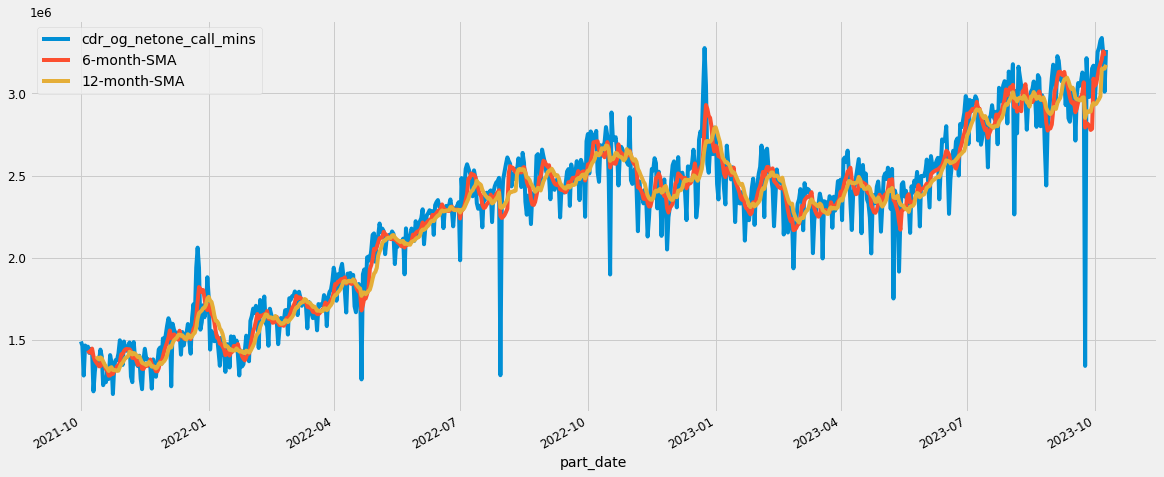

In [210]:
df2.plot();

# Exponentially moving Average
We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:

Smaller windows will lead to more noise, rather than signal
It will always lag by the size of the window
It will never reach to full peak or valley of the data due to the averaging.
Does not really inform you about possible future behavior, all it really does is describe trends in your data.
Extreme historical values can skew your SMA significantly

In [212]:
data['EWMA12'] = data['cdr_og_netone_call_mins'].ewm(span=12,adjust=False).mean()


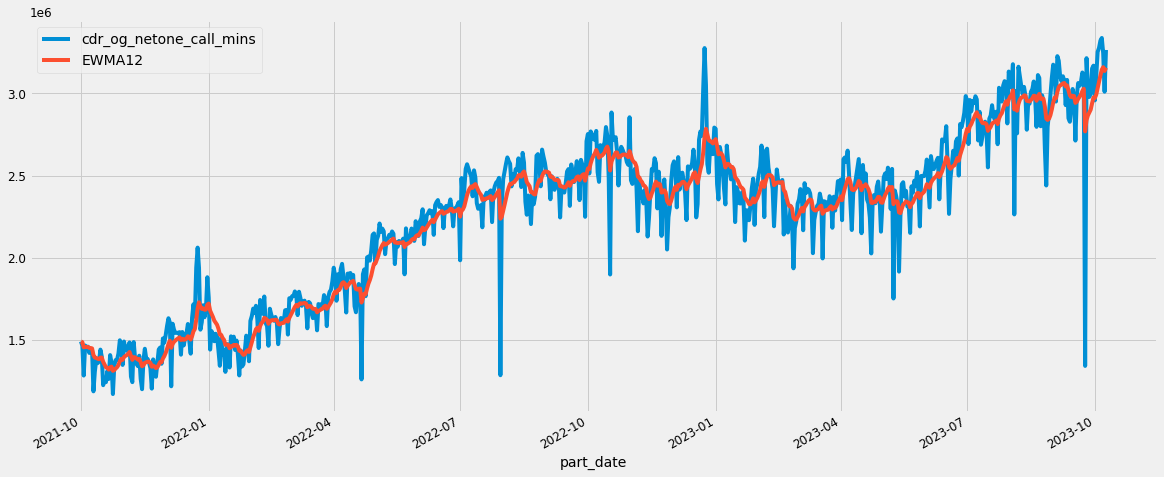

In [213]:
data[['cdr_og_netone_call_mins','EWMA12']].plot();

# comparing sma to ema 

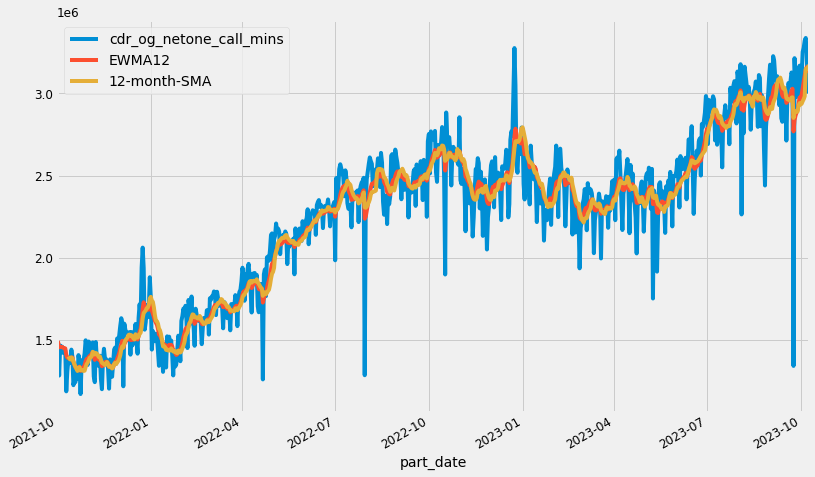

In [214]:
data[['cdr_og_netone_call_mins','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

Simple Exponential Smoothing with one smoothing factor α. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above

In [230]:
df11=pd.read_csv(r'C:\Users\uddandam.prakash\Downloads\tsa_model_base_v1.csv')

In [231]:
df11.head()

,part_date,cdr_og_netone_call_cnt,cdr_og_netone_call_mins,tariff_rate,termination_rate,rtgs_interbank_exchange
0,20211001,1701336,1492856,2.8083,0.2,175
1,20211002,1696106,1467425,2.8083,0.2,175
2,20211003,1453001,1285924,2.8083,0.2,175
3,20211004,1640321,1468526,2.8083,0.2,175
4,20211005,1634891,1458419,2.8083,0.2,175


In [232]:
df12=df11[['part_date','cdr_og_netone_call_mins']]

In [233]:
df12['part_date'] = pd.to_datetime(df12['part_date'], format='%Y%m%d')
df12.set_index('part_date', inplace=True)

In [234]:
df12.shape

(733, 1)

In [235]:
train_data = df12.iloc[:500] # Goes up to but not including 109
test_data = df12.iloc[500:]

In [236]:
train_data.head()

,cdr_og_netone_call_mins
part_date,
2021-10-01,1492856
2021-10-02,1467425
2021-10-03,1285924
2021-10-04,1468526
2021-10-05,1458419


In [237]:
train_data.shape,test_data.shape

((500, 1), (233, 1))

In [238]:
# fitting the model 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model=ExponentialSmoothing(train_data['cdr_og_netone_call_mins'], trend='mul', seasonal='mul', seasonal_periods=12).fit()

In [239]:
# Let's do the forecast. Ignore the warings as it is related to statsmodels
predictions=fitted_model.forecast(200).rename("Forecast")
predictions

2023-02-13    2.367014e+06
2023-02-14    2.339790e+06
2023-02-15    2.364132e+06
2023-02-16    2.354015e+06
2023-02-17    2.333638e+06
                  ...     
2023-08-27    2.080003e+06
2023-08-28    2.061998e+06
2023-08-29    2.105024e+06
2023-08-30    2.074805e+06
2023-08-31    2.073971e+06
Freq: D, Name: Forecast, Length: 200, dtype: float64

<AxesSubplot:xlabel='part_date'>

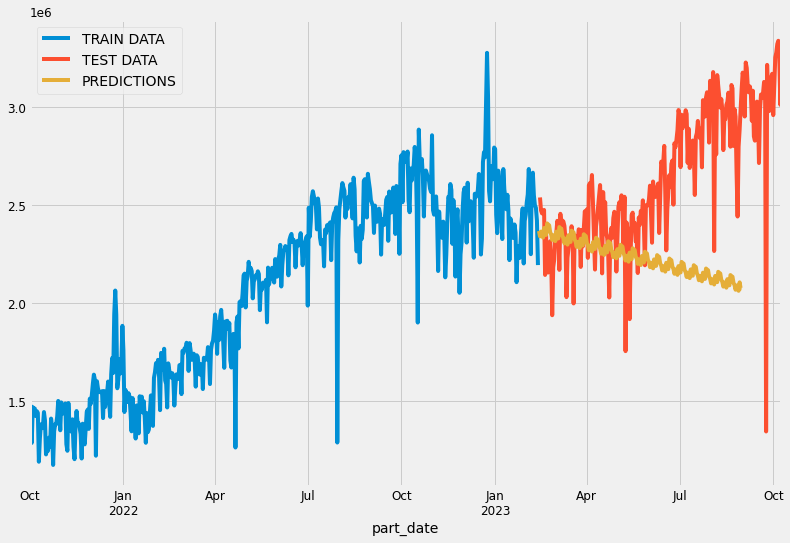

In [240]:
train_data['cdr_og_netone_call_mins'].plot(legend=True, label="TRAIN DATA")
test_data['cdr_og_netone_call_mins'].plot(legend=True, label="TEST DATA", figsize=(12,8))
predictions.plot(legend=True, label='PREDICTIONS')

<AxesSubplot:xlabel='part_date'>

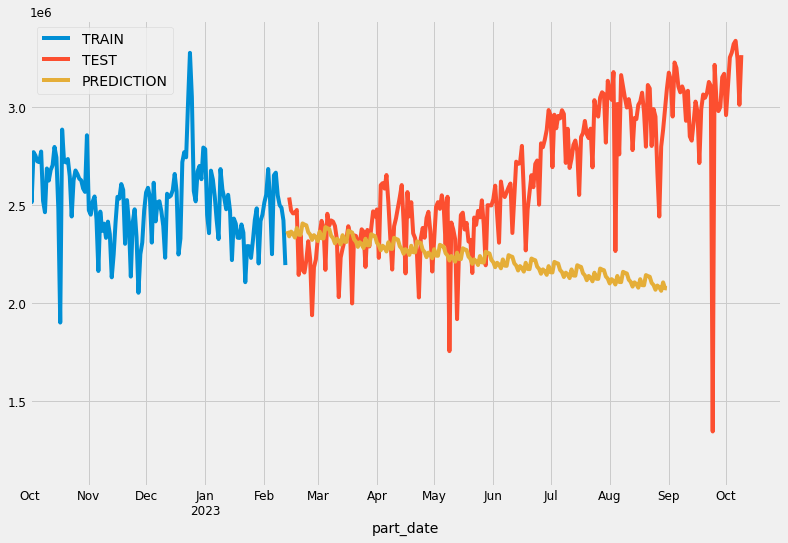

In [242]:
train_data['cdr_og_netone_call_mins'].plot(legend=True,label='TRAIN')
test_data['cdr_og_netone_call_mins'].plot(legend=True,label='TEST',figsize=(12,8))
predictions.plot(legend=True,label='PREDICTION',xlim=['2022-10-01','2023-10-30'])

In [243]:
# evaluating predictions 

In [244]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [246]:
predictions

2023-02-13    2.367014e+06
2023-02-14    2.339790e+06
2023-02-15    2.364132e+06
2023-02-16    2.354015e+06
2023-02-17    2.333638e+06
                  ...     
2023-08-27    2.080003e+06
2023-08-28    2.061998e+06
2023-08-29    2.105024e+06
2023-08-30    2.074805e+06
2023-08-31    2.073971e+06
Freq: D, Name: Forecast, Length: 200, dtype: float64

In [248]:
from sklearn.metrics import mean_absolute_error

# Ensure test_data and predictions have the same number of samples
test_data = test_data.iloc[:200]
mae = mean_absolute_error(test_data, predictions)


In [249]:
mae

401978.7563522548

The Root Mean Squared Error of our forecasts is 151.64

In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

In [251]:
data.columns

Index(['cdr_og_netone_call_cnt', 'cdr_og_netone_call_mins', 'tariff_rate',
       'termination_rate', 'rtgs_interbank_exchange', 'trend', '6-month-SMA',
       '12-month-SMA', 'EWMA12'],
      dtype='object')

In [250]:
np.sqrt(mean_squared_error(test_data,predictions))

522268.4197960935

In [260]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import numpy as np

# Define the evaluation function (Mean Absolute Error)
def evaluate(true_values, predicted_values):
    mae = np.mean(np.abs(true_values - predicted_values))
    return mae

# Your code for creating the 'train_data' and 'test_data'

# ...

index = len(train_data)
yhat = list()

for t in tqdm(range(len(test_data.cdr_og_netone_call_mins))):
    temp_train = df12[:len(train_data) + t]
    
    # Create an ARIMA model with order (1, 1, 0) for ARMA(1,1) modeling
    model = ARIMA(temp_train.cdr_og_netone_call_mins, order=(1, 1, 0))
    
    # Fit the model
    model_fit = model.fit()
    
    # Predict 1 step ahead
    predictions = model_fit.forecast(steps=1)
    
    # Append the prediction to the yhat list
    yhat.extend(predictions)

# Convert the list of predictions to a Pandas Series
yhat = pd.Series(yhat)

# Evaluate the model and store the results
resultsDict['ARMA'] = evaluate(test_data.cdr_og_netone_call_mins, yhat)
predictionsDict['ARMA'] = yhat.values


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.94it/s]


In [262]:
predictionsDict['ARMA']

array([2258585.94385455, 2437814.15521414, 2491529.26517811,
       2461516.68664836, 2457620.58522361, 2469622.76531239,
       2239345.86465414, 2285755.6346052 , 2220323.07622916,
       2159073.01295534, 2199031.13785627, 2286253.30586031,
       2250777.52638024, 2021119.26580878, 2110110.13546885,
       2210178.84867071, 2298004.98386406, 2348740.46180078,
       2400761.62594215, 2395432.22719495, 2232179.52947293,
       2370586.80243117, 2412233.53028338, 2413118.23228038,
       2416864.93533796, 2399421.34384876, 2344955.70074717,
       2116153.90888533, 2172044.00854548, 2264177.64395438,
       2305444.17757264, 2322879.14490398, 2372014.63252664,
       2362819.56803803, 2100990.10067263, 2241596.68054284,
       2342795.53753093, 2314372.67999068, 2303611.94053407,
       2354545.37055364, 2367253.74593541, 2237072.00868105,
       2316509.46365325, 2313368.63860103, 2353388.9435888 ,
       2441746.90941227, 2449023.50756269, 2466393.30723883,
       2303627.09608312,

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.68it/s]


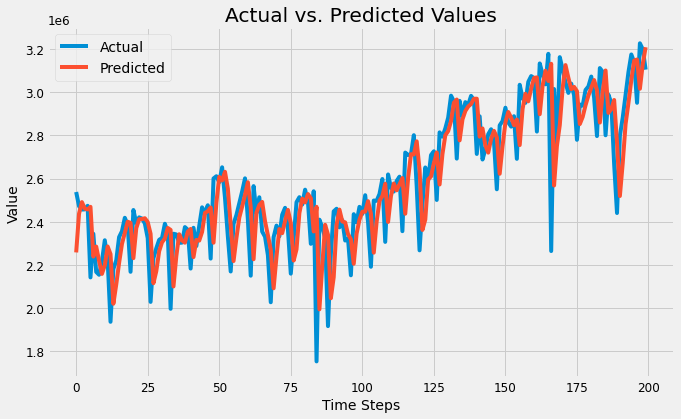

In [263]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Define the evaluation function (Mean Absolute Error)
def evaluate(true_values, predicted_values):
    mae = np.mean(np.abs(true_values - predicted_values))
    return mae

# Your code for creating the 'train_data' and 'test_data'

# ...

index = len(train_data)
yhat = list()
actual = list()  # To store actual values

for t in tqdm(range(len(test_data.cdr_og_netone_call_mins))):
    temp_train = df12[:len(train_data) + t]
    
    # Create an ARIMA model with order (1, 1, 0) for ARMA(1,1) modeling
    model = ARIMA(temp_train.cdr_og_netone_call_mins, order=(1, 1, 0))
    
    # Fit the model
    model_fit = model.fit()
    
    # Predict 1 step ahead
    predictions = model_fit.forecast(steps=1)
    
    # Append the prediction to the yhat list
    yhat.extend(predictions)
    
    # Append the actual value to the actual list
    actual.append(test_data.cdr_og_netone_call_mins.iloc[t])

# Convert the list of predictions to a Pandas Series
yhat = pd.Series(yhat)

# Evaluate the model and store the results
mae = evaluate(actual, yhat)
resultsDict['ARMA'] = mae
predictionsDict['ARMA'] = yhat.values

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(yhat.values, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.show()


In [ ]:
Step 4: Model Selection

In this case, we'll use an ARIMA model, which stands for AutoRegressive Integrated Moving Average. ARIMA models are a class of models for time series forecasting. The model order, denoted as (p, d, q), determines the number of autoregressive (AR) terms (p), differencing (d), and moving average (MA) terms (q). To select the order, you can analyze the autocorrelation and partial autocorrelation plots, but a full search for the best order is often necessary.

python

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Create and fit the ARIMA model
model = ARIMA(data['cdr_og_netone_call_mins'], order=(1, 1, 1))
model_fit = model.fit()

Step 5: Model Training

We've already trained the ARIMA model in the code above.
Step 6: Model Evaluation

To evaluate the model's performance, we can use common metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). In this example, we'll calculate and print the RMSE:

python

from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on the testing data
predictions = model_fit.forecast(steps=len(data) - len(train_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['cdr_og_netone_call_mins'], predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Step 7: Model Hyperparameter Tuning

In this simple example, we used a fixed order (1, 1, 1) for the ARIMA model. You may need to perform hyperparameter tuning to find the best order for your specific dataset. A common approach is grid search over a range of potential orders.
Step 8: Forecasting

Finally, you can use the trained model to make future predictions. In this example, we'll forecast the next 10 time steps:

python

# Forecast the next 10 time steps
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted values:")
print(forecast)

These steps outline the process of building a basic ARIMA time series forecasting model. Depending on your specific needs and the characteristics of your data, you might explore more advanced models, such as SARIMA or Prophet, and perform additional tasks like seasonality detection and outlier handling.

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

# Load the sample data (replace 'data.csv' with the actual file path)
data = pd.read_csv('data.csv')

# Define independent variables (features) and dependent variable (target)
independent_vars = ['cdr_og_netone_call_mins', 'tariff_rate', 'termination_rate', 'rtgs_interbank_exchange']
dependent_var = 'cdr_og_netone_call_cnt'

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create and fit the ARIMA model
model = ARIMA(train_data[dependent_var], order=(1, 1, 1))
model_fit = model.fit()

# Make predictions on the testing data
predictions = model_fit.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(np.mean((test_data[dependent_var] - predictions) ** 2))

# Print RMSE
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data[dependent_var], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel(dependent_var)
plt.legend()
plt.show()

# Forecast future values
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted values:")
print(forecast)

This code performs the following:

    Loads the sample data and defines the independent and dependent variables.
    Splits the data into training and testing sets.
    Creates an ARIMA model, fits it to the training data, and makes predictions on the testing data.
    Calculates the RMSE for model evaluation.
    Plots the actual vs. predicted values.
    Forecasts future values for the dependent variable.

Remember to update the 'data.csv' file path with the actual path of your dataset. Additionally, the model order (1, 1, 1) is used as an example; you may need to tune the order based on the characteristics of your data.